# Imports

In [169]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import tqdm

#Variables

In [170]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 128
LR= 0.01
NUM_EPOCHS=15

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

# Loading Dataset

In [171]:
def load_and_prep_cifar(batch_size, shuffle_buffer_size):
  #train, test = tfds.load('cifar10', split=['train','test'], as_supervised=True)
  train_ds, test_ds= tfds.load('cifar10', split=['train','test'] , as_supervised=True)

  def preprocessing_func(img, label):
    img = tf.cast(img, tf.float32)
    img = (img/128)-1
    label = tf.one_hot(label, depth = 10)
    return img, label


  train_ds = train_ds.map(lambda img, label: preprocessing_func(img,label))
  test_ds = test_ds.map(lambda img, label: preprocessing_func(img,label))
  train_ds = train_ds.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(2)
  test_ds = test_ds.batch(batch_size).prefetch(2)
  return train_ds, test_ds

train_ds, test_ds = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)

In [172]:
for img1, label in train_ds.take(3):
  print(img1.shape, label.shape)

(128, 32, 32, 3) (128, 10)
(128, 32, 32, 3) (128, 10)
(128, 32, 32, 3) (128, 10)


# Model

In [173]:
def create_my_cifar_cnn(name='my_cnn', number_blocks=3, number_layers_block=2):
    # Define the input layer with shape (32, 32, 3)
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)
    x = inputs  # Initialize x with the input layer

    # Create convolutional blocks
    for i in range(1, number_blocks + 1):
        for j in range(number_layers_block):
            # Add convolutional layers with increasing filters and ReLU activation
            x = tf.keras.layers.Conv2D(filters=i * 16, kernel_size=(3, 3), activation='relu', padding='same')(x)

        # Add max pooling layer after each block, except for the last one
        if i != number_blocks:
            x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

    # Flatten the output for the fully connected layers
    x = tf.keras.layers.Flatten()(x)

    # Add a dense layer with 64 units and ReLU activation
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # Add the output layer with 10 units (for 10 classes) and softmax activation
    output = tf.keras.layers.Dense(10, activation='softmax')(x)

    # Create and return the model
    model = tf.keras.Model(inputs, output, name=name)
    return model

#Train_Model

In [174]:
def train_cifar_10(model, train_ds, test_ds, num_epochs, lr):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy = tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, predictions)

    @tf.function
    def test_step(images, labels):
        predictions = model(images)
        t_loss = loss_object(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

    for epoch in tqdm.tqdm(range(num_epochs)):
        # Training loop
        for images, labels in train_ds:
            train_step(images, labels)

        # Testing loop
        for test_images, test_labels in test_ds:
            test_step(test_images, test_labels)

        # Save metrics for plotting
        train_losses.append(train_loss.result().numpy())
        train_accuracies.append(train_accuracy.result().numpy())
        test_losses.append(test_loss.result().numpy())
        test_accuracies.append(test_accuracy.result().numpy())

        template = ' Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
        print(template.format(epoch + 1,
                              train_loss.result(),
                              train_accuracy.result() * 100,
                              test_loss.result(),
                              test_accuracy.result() * 100))

        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

    # Plotting
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

#Calls

**learning rate of 0.01 and Optimizer Adam, 3 blocks with 2 CNNs in each**

  7%|▋         | 1/15 [00:13<03:14, 13.87s/it]

 Epoch 1, Loss: 1.7898, Accuracy: 33.88%, Test Loss: 1.5478, Test Accuracy: 42.58%


 13%|█▎        | 2/15 [00:17<01:41,  7.79s/it]

 Epoch 2, Loss: 1.4617, Accuracy: 46.65%, Test Loss: 1.4199, Test Accuracy: 48.60%


 20%|██        | 3/15 [00:21<01:11,  6.00s/it]

 Epoch 3, Loss: 1.3812, Accuracy: 49.76%, Test Loss: 1.3908, Test Accuracy: 49.02%


 27%|██▋       | 4/15 [00:26<01:02,  5.66s/it]

 Epoch 4, Loss: 1.3255, Accuracy: 52.20%, Test Loss: 1.3928, Test Accuracy: 49.21%


 33%|███▎      | 5/15 [00:30<00:49,  4.96s/it]

 Epoch 5, Loss: 1.3176, Accuracy: 52.58%, Test Loss: 1.2847, Test Accuracy: 53.66%


 40%|████      | 6/15 [00:33<00:41,  4.56s/it]

 Epoch 6, Loss: 1.2794, Accuracy: 53.85%, Test Loss: 1.3572, Test Accuracy: 51.57%


 47%|████▋     | 7/15 [00:38<00:36,  4.53s/it]

 Epoch 7, Loss: 1.2466, Accuracy: 55.20%, Test Loss: 1.3429, Test Accuracy: 52.58%


 53%|█████▎    | 8/15 [00:44<00:34,  4.99s/it]

 Epoch 8, Loss: 1.2402, Accuracy: 55.38%, Test Loss: 1.3273, Test Accuracy: 53.24%


 60%|██████    | 9/15 [00:50<00:31,  5.23s/it]

 Epoch 9, Loss: 1.2144, Accuracy: 56.39%, Test Loss: 1.3355, Test Accuracy: 53.01%


 67%|██████▋   | 10/15 [00:55<00:25,  5.13s/it]

 Epoch 10, Loss: 1.2133, Accuracy: 56.57%, Test Loss: 1.3459, Test Accuracy: 52.72%


 73%|███████▎  | 11/15 [01:00<00:20,  5.10s/it]

 Epoch 11, Loss: 1.1998, Accuracy: 57.21%, Test Loss: 1.2656, Test Accuracy: 55.29%


 80%|████████  | 12/15 [01:10<00:20,  6.81s/it]

 Epoch 12, Loss: 1.1909, Accuracy: 57.30%, Test Loss: 1.2511, Test Accuracy: 55.44%


 87%|████████▋ | 13/15 [01:16<00:12,  6.49s/it]

 Epoch 13, Loss: 1.1755, Accuracy: 57.86%, Test Loss: 1.2624, Test Accuracy: 55.39%


 93%|█████████▎| 14/15 [01:21<00:06,  6.11s/it]

 Epoch 14, Loss: 1.1667, Accuracy: 58.30%, Test Loss: 1.2874, Test Accuracy: 55.50%


100%|██████████| 15/15 [01:25<00:00,  5.71s/it]

 Epoch 15, Loss: 1.1662, Accuracy: 58.17%, Test Loss: 1.2727, Test Accuracy: 54.66%


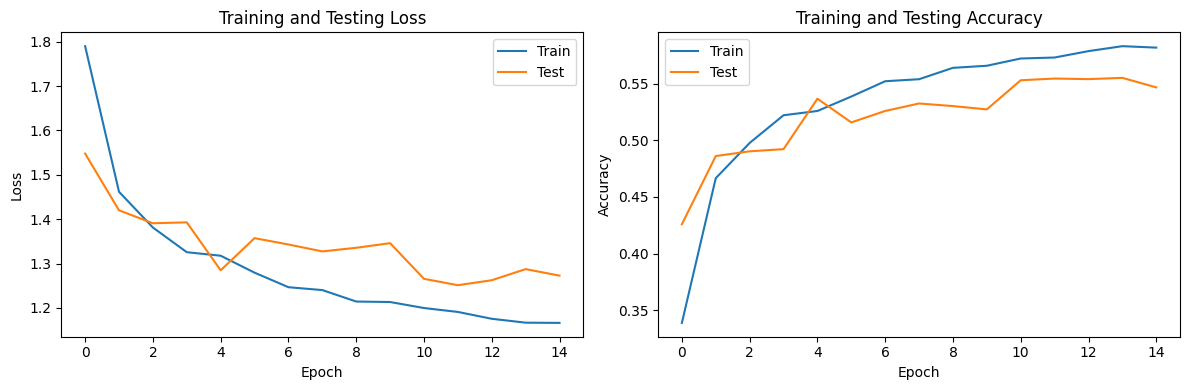

79/79 [==============================] - 1s 7ms/step - loss: 1.2670 - accuracy: 0.5466 - categorical_accuracy: 0.5466
Test Accuracy: 54.66%


In [175]:
#learning rate of 0.01 and Optimizer Adam, 3 blocks with 2 CNNs in each
# Train the model using the defined function
LR=0.01
model = create_my_cifar_cnn()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

train_cifar_10(model, train_ds, test_ds, NUM_EPOCHS, LR)

# Evaluate the model on the test set
test_metrics = model.evaluate(test_ds)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

**learning rate of 0.001 and Optimizer Adam, 3 blocks with 2 CNNs in each**

  7%|▋         | 1/15 [00:11<02:41, 11.52s/it]

 Epoch 1, Loss: 1.5790, Accuracy: 42.01%, Test Loss: 1.2997, Test Accuracy: 52.74%


 13%|█▎        | 2/15 [00:14<01:27,  6.76s/it]

 Epoch 2, Loss: 1.1739, Accuracy: 57.97%, Test Loss: 1.0695, Test Accuracy: 62.14%


 20%|██        | 3/15 [00:20<01:14,  6.24s/it]

 Epoch 3, Loss: 0.9687, Accuracy: 65.67%, Test Loss: 0.9579, Test Accuracy: 66.67%


 27%|██▋       | 4/15 [00:26<01:06,  6.05s/it]

 Epoch 4, Loss: 0.8377, Accuracy: 70.57%, Test Loss: 0.9141, Test Accuracy: 68.49%


 33%|███▎      | 5/15 [00:32<01:01,  6.18s/it]

 Epoch 5, Loss: 0.7405, Accuracy: 73.93%, Test Loss: 0.8632, Test Accuracy: 70.32%


 40%|████      | 6/15 [00:36<00:48,  5.38s/it]

 Epoch 6, Loss: 0.6610, Accuracy: 76.79%, Test Loss: 0.8591, Test Accuracy: 71.57%


 47%|████▋     | 7/15 [00:42<00:44,  5.50s/it]

 Epoch 7, Loss: 0.5933, Accuracy: 79.18%, Test Loss: 0.8668, Test Accuracy: 71.33%


 53%|█████▎    | 8/15 [00:48<00:39,  5.58s/it]

 Epoch 8, Loss: 0.5242, Accuracy: 81.85%, Test Loss: 0.8409, Test Accuracy: 72.71%


 60%|██████    | 9/15 [00:51<00:30,  5.04s/it]

 Epoch 9, Loss: 0.4678, Accuracy: 83.70%, Test Loss: 0.8825, Test Accuracy: 72.99%


 67%|██████▋   | 10/15 [00:55<00:22,  4.57s/it]

 Epoch 10, Loss: 0.4100, Accuracy: 85.69%, Test Loss: 0.9422, Test Accuracy: 72.49%


 73%|███████▎  | 11/15 [01:00<00:19,  4.76s/it]

 Epoch 11, Loss: 0.3580, Accuracy: 87.39%, Test Loss: 1.0461, Test Accuracy: 72.21%


 80%|████████  | 12/15 [01:04<00:13,  4.47s/it]

 Epoch 12, Loss: 0.3144, Accuracy: 88.84%, Test Loss: 1.1432, Test Accuracy: 71.08%


 87%|████████▋ | 13/15 [01:10<00:09,  4.86s/it]

 Epoch 13, Loss: 0.2747, Accuracy: 90.09%, Test Loss: 1.2052, Test Accuracy: 71.88%


 93%|█████████▎| 14/15 [01:15<00:04,  4.94s/it]

 Epoch 14, Loss: 0.2381, Accuracy: 91.61%, Test Loss: 1.2632, Test Accuracy: 72.06%


100%|██████████| 15/15 [01:19<00:00,  5.27s/it]

 Epoch 15, Loss: 0.2034, Accuracy: 92.64%, Test Loss: 1.4619, Test Accuracy: 70.74%


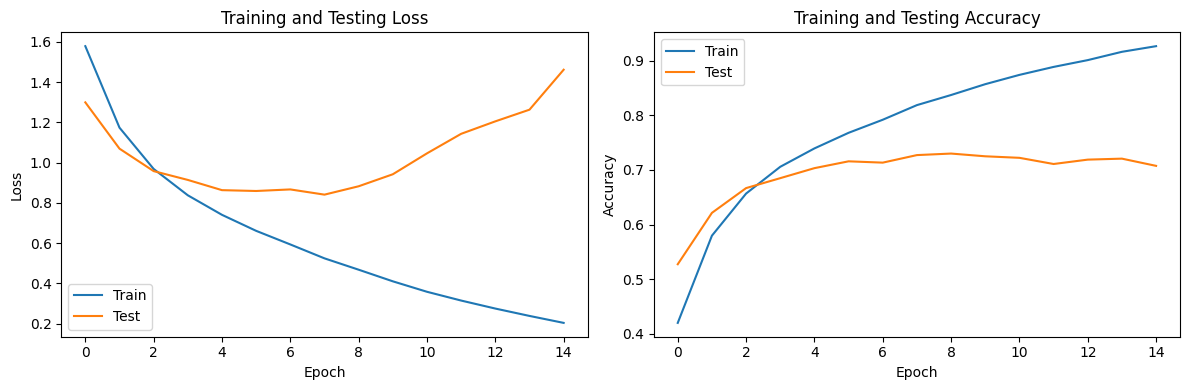

79/79 [==============================] - 1s 6ms/step - loss: 1.4569 - accuracy: 0.7074 - categorical_accuracy: 0.7074
Test Accuracy: 70.74%


In [176]:
#learning rate of 0.001 and Optimizer Adam, 3 blocks with 2 CNNs in each
# Train the model using the defined function
LR=0.001
model = create_my_cifar_cnn()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

train_cifar_10(model, train_ds, test_ds, NUM_EPOCHS, LR)

# Evaluate the model on the test set
test_metrics = model.evaluate(test_ds)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

**learning rate of 0.01 and Optimizer AdamGrad, 3 blocks with 2 CNNs in each**

  7%|▋         | 1/15 [00:07<01:44,  7.46s/it]

 Epoch 1, Loss: 1.8731, Accuracy: 29.87%, Test Loss: 1.5907, Test Accuracy: 41.37%


 13%|█▎        | 2/15 [00:11<01:09,  5.38s/it]

 Epoch 2, Loss: 1.5510, Accuracy: 43.00%, Test Loss: 1.5258, Test Accuracy: 44.96%


 20%|██        | 3/15 [00:17<01:10,  5.84s/it]

 Epoch 3, Loss: 1.4714, Accuracy: 46.23%, Test Loss: 1.4957, Test Accuracy: 44.57%


 27%|██▋       | 4/15 [00:22<00:58,  5.35s/it]

 Epoch 4, Loss: 1.4356, Accuracy: 47.79%, Test Loss: 1.4747, Test Accuracy: 46.74%


 33%|███▎      | 5/15 [00:26<00:47,  4.79s/it]

 Epoch 5, Loss: 1.4152, Accuracy: 48.47%, Test Loss: 1.4324, Test Accuracy: 47.79%


 40%|████      | 6/15 [00:29<00:40,  4.45s/it]

 Epoch 6, Loss: 1.3948, Accuracy: 49.44%, Test Loss: 1.4085, Test Accuracy: 49.06%


 47%|████▋     | 7/15 [00:35<00:37,  4.66s/it]

 Epoch 7, Loss: 1.3813, Accuracy: 50.12%, Test Loss: 1.4198, Test Accuracy: 48.83%


 53%|█████▎    | 8/15 [00:38<00:30,  4.42s/it]

 Epoch 8, Loss: 1.3643, Accuracy: 50.74%, Test Loss: 1.4219, Test Accuracy: 49.14%


 60%|██████    | 9/15 [00:44<00:29,  4.85s/it]

 Epoch 9, Loss: 1.3433, Accuracy: 51.56%, Test Loss: 1.3933, Test Accuracy: 50.59%


 67%|██████▋   | 10/15 [00:49<00:23,  4.77s/it]

 Epoch 10, Loss: 1.3303, Accuracy: 51.95%, Test Loss: 1.4312, Test Accuracy: 48.77%


 73%|███████▎  | 11/15 [00:55<00:20,  5.07s/it]

 Epoch 11, Loss: 1.3408, Accuracy: 51.71%, Test Loss: 1.4665, Test Accuracy: 47.43%


 80%|████████  | 12/15 [01:00<00:15,  5.15s/it]

 Epoch 12, Loss: 1.3254, Accuracy: 52.32%, Test Loss: 1.3807, Test Accuracy: 50.81%


 87%|████████▋ | 13/15 [01:04<00:09,  4.72s/it]

 Epoch 13, Loss: 1.3228, Accuracy: 52.48%, Test Loss: 1.4052, Test Accuracy: 50.17%


 93%|█████████▎| 14/15 [01:07<00:04,  4.44s/it]

 Epoch 14, Loss: 1.3043, Accuracy: 52.90%, Test Loss: 1.4618, Test Accuracy: 48.53%


100%|██████████| 15/15 [01:13<00:00,  4.91s/it]

 Epoch 15, Loss: 1.3026, Accuracy: 53.34%, Test Loss: 1.4204, Test Accuracy: 50.13%


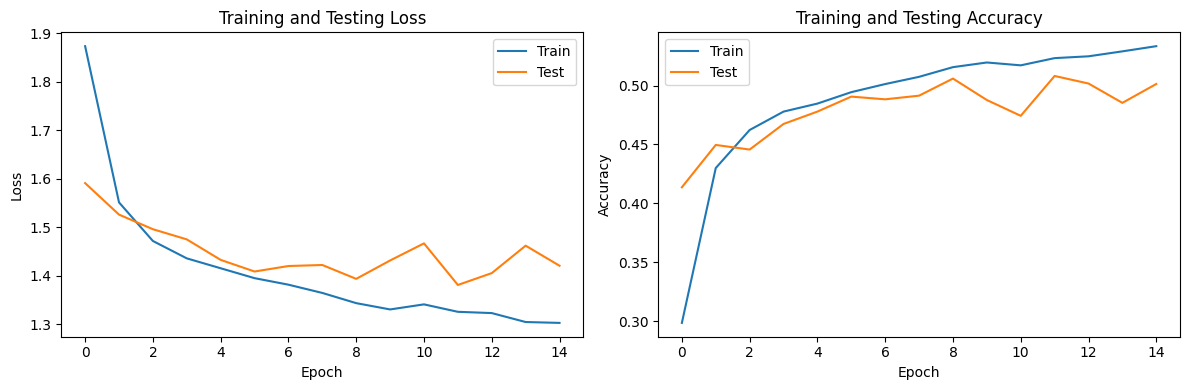

79/79 [==============================] - 1s 7ms/step - loss: 1.4183 - accuracy: 0.5013 - categorical_accuracy: 0.5013
Test Accuracy: 50.13%


In [177]:
#learning rate of 0.01 and Optimizer AdamGrad, 3 blocks with 2 CNNs in each
# Train the model using the defined function
LR=0.01
model = create_my_cifar_cnn()
model.compile(optimizer=tf.keras.optimizers.experimental.Adagrad(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

train_cifar_10(model, train_ds, test_ds, NUM_EPOCHS, LR)

# Evaluate the model on the test set
test_metrics = model.evaluate(test_ds)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

**learning rate of 0.001 and Optimizer AdamGrad, 3 blocks with 2 CNNs in each**

  7%|▋         | 1/15 [00:08<01:52,  8.00s/it]

 Epoch 1, Loss: 1.5252, Accuracy: 44.84%, Test Loss: 1.2659, Test Accuracy: 55.10%


 13%|█▎        | 2/15 [00:13<01:23,  6.45s/it]

 Epoch 2, Loss: 1.0983, Accuracy: 61.00%, Test Loss: 1.0611, Test Accuracy: 62.36%


 20%|██        | 3/15 [00:17<01:03,  5.27s/it]

 Epoch 3, Loss: 0.9115, Accuracy: 67.84%, Test Loss: 0.9027, Test Accuracy: 68.35%


 27%|██▋       | 4/15 [00:23<01:02,  5.72s/it]

 Epoch 4, Loss: 0.7944, Accuracy: 72.05%, Test Loss: 0.8317, Test Accuracy: 71.25%


 33%|███▎      | 5/15 [00:27<00:51,  5.18s/it]

 Epoch 5, Loss: 0.6954, Accuracy: 75.45%, Test Loss: 0.8304, Test Accuracy: 71.81%


 40%|████      | 6/15 [00:33<00:48,  5.38s/it]

 Epoch 6, Loss: 0.6245, Accuracy: 78.12%, Test Loss: 0.8120, Test Accuracy: 73.05%


 47%|████▋     | 7/15 [00:39<00:43,  5.49s/it]

 Epoch 7, Loss: 0.5522, Accuracy: 80.58%, Test Loss: 0.7925, Test Accuracy: 74.06%


 53%|█████▎    | 8/15 [00:43<00:35,  5.08s/it]

 Epoch 8, Loss: 0.4889, Accuracy: 82.83%, Test Loss: 0.8643, Test Accuracy: 72.77%


 60%|██████    | 9/15 [00:50<00:33,  5.51s/it]

 Epoch 9, Loss: 0.4298, Accuracy: 84.84%, Test Loss: 0.8890, Test Accuracy: 74.20%


 67%|██████▋   | 10/15 [00:54<00:26,  5.30s/it]

 Epoch 10, Loss: 0.3700, Accuracy: 86.96%, Test Loss: 0.9640, Test Accuracy: 73.26%


 73%|███████▎  | 11/15 [01:00<00:21,  5.44s/it]

 Epoch 11, Loss: 0.3212, Accuracy: 88.62%, Test Loss: 1.0244, Test Accuracy: 72.47%


 80%|████████  | 12/15 [01:06<00:16,  5.54s/it]

 Epoch 12, Loss: 0.2807, Accuracy: 90.20%, Test Loss: 1.0849, Test Accuracy: 72.69%


 87%|████████▋ | 13/15 [01:10<00:10,  5.15s/it]

 Epoch 13, Loss: 0.2362, Accuracy: 91.63%, Test Loss: 1.2474, Test Accuracy: 72.27%


 93%|█████████▎| 14/15 [01:14<00:04,  4.87s/it]

 Epoch 14, Loss: 0.2096, Accuracy: 92.50%, Test Loss: 1.2612, Test Accuracy: 71.97%


100%|██████████| 15/15 [01:20<00:00,  5.36s/it]

 Epoch 15, Loss: 0.1768, Accuracy: 93.85%, Test Loss: 1.4265, Test Accuracy: 72.00%


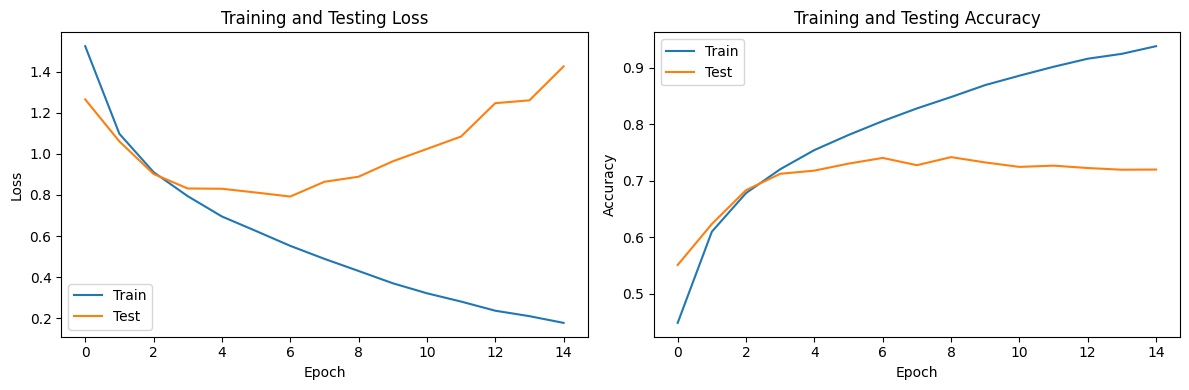

79/79 [==============================] - 1s 7ms/step - loss: 1.4299 - accuracy: 0.7200 - categorical_accuracy: 0.7200
Test Accuracy: 72.00%


In [178]:
#learning rate of 0.001 and Optimizer AdamGrad, 3 blocks with 2 CNNs in each
# Train the model using the defined function
LR=0.001
model = create_my_cifar_cnn()
model.compile(optimizer=tf.keras.optimizers.experimental.Adagrad(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

train_cifar_10(model, train_ds, test_ds, NUM_EPOCHS, LR)

# Evaluate the model on the test set
test_metrics = model.evaluate(test_ds)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

**learning rate of 0.01 and Optimizer Adam, 2 blocks with 2 CNNs in each**

  7%|▋         | 1/15 [00:06<01:28,  6.31s/it]

 Epoch 1, Loss: 1.6726, Accuracy: 38.88%, Test Loss: 1.4663, Test Accuracy: 45.35%


 13%|█▎        | 2/15 [00:11<01:11,  5.51s/it]

 Epoch 2, Loss: 1.3733, Accuracy: 50.36%, Test Loss: 1.3293, Test Accuracy: 52.57%


 20%|██        | 3/15 [00:17<01:07,  5.62s/it]

 Epoch 3, Loss: 1.2530, Accuracy: 54.92%, Test Loss: 1.3429, Test Accuracy: 52.95%


 27%|██▋       | 4/15 [00:20<00:53,  4.86s/it]

 Epoch 4, Loss: 1.1999, Accuracy: 56.91%, Test Loss: 1.3672, Test Accuracy: 54.43%


 33%|███▎      | 5/15 [00:25<00:48,  4.87s/it]

 Epoch 5, Loss: 1.1443, Accuracy: 59.09%, Test Loss: 1.3163, Test Accuracy: 55.53%


 40%|████      | 6/15 [00:31<00:46,  5.17s/it]

 Epoch 6, Loss: 1.1079, Accuracy: 60.37%, Test Loss: 1.3584, Test Accuracy: 54.61%


 47%|████▋     | 7/15 [00:34<00:37,  4.64s/it]

 Epoch 7, Loss: 1.0654, Accuracy: 62.10%, Test Loss: 1.3929, Test Accuracy: 54.72%


 53%|█████▎    | 8/15 [00:40<00:33,  4.80s/it]

 Epoch 8, Loss: 1.0294, Accuracy: 63.39%, Test Loss: 1.4623, Test Accuracy: 53.73%


 60%|██████    | 9/15 [00:43<00:26,  4.42s/it]

 Epoch 9, Loss: 0.9962, Accuracy: 64.27%, Test Loss: 1.6425, Test Accuracy: 52.18%


 67%|██████▋   | 10/15 [00:49<00:24,  4.83s/it]

 Epoch 10, Loss: 0.9661, Accuracy: 65.54%, Test Loss: 1.5320, Test Accuracy: 53.32%


 73%|███████▎  | 11/15 [00:55<00:20,  5.11s/it]

 Epoch 11, Loss: 0.9237, Accuracy: 67.08%, Test Loss: 1.7072, Test Accuracy: 52.71%


 80%|████████  | 12/15 [00:58<00:13,  4.63s/it]

 Epoch 12, Loss: 0.8945, Accuracy: 67.89%, Test Loss: 1.7680, Test Accuracy: 51.98%


 87%|████████▋ | 13/15 [01:02<00:08,  4.30s/it]

 Epoch 13, Loss: 0.8647, Accuracy: 69.10%, Test Loss: 1.9437, Test Accuracy: 50.29%


 93%|█████████▎| 14/15 [01:06<00:04,  4.37s/it]

 Epoch 14, Loss: 0.8495, Accuracy: 69.79%, Test Loss: 1.9664, Test Accuracy: 51.85%


100%|██████████| 15/15 [01:12<00:00,  4.83s/it]

 Epoch 15, Loss: 0.8208, Accuracy: 70.70%, Test Loss: 1.9796, Test Accuracy: 50.90%


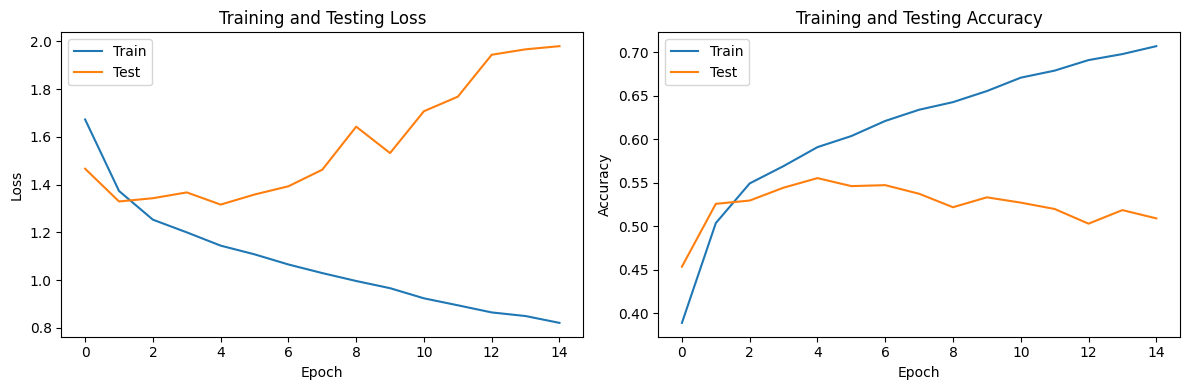

79/79 [==============================] - 1s 7ms/step - loss: 1.9746 - accuracy: 0.5090 - categorical_accuracy: 0.5090
Test Accuracy: 50.90%


In [179]:
#learning rate of 0.01 and Optimizer Adam, 2 blocks with 2 CNNs in each
# Train the model using the defined function
LR=0.01
model = create_my_cifar_cnn(number_blocks=2)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

train_cifar_10(model, train_ds, test_ds, NUM_EPOCHS, LR)

# Evaluate the model on the test set
test_metrics = model.evaluate(test_ds)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

**learning rate of 0.001 and Optimizer Adam, 2 blocks with 2 CNNs in each**

  7%|▋         | 1/15 [00:10<02:32, 10.93s/it]

 Epoch 1, Loss: 1.4509, Accuracy: 48.14%, Test Loss: 1.1715, Test Accuracy: 58.64%


 13%|█▎        | 2/15 [00:14<01:24,  6.50s/it]

 Epoch 2, Loss: 1.0603, Accuracy: 62.54%, Test Loss: 1.0137, Test Accuracy: 64.16%


 20%|██        | 3/15 [00:20<01:13,  6.16s/it]

 Epoch 3, Loss: 0.9038, Accuracy: 68.32%, Test Loss: 0.9308, Test Accuracy: 67.08%


 27%|██▋       | 4/15 [00:23<00:56,  5.16s/it]

 Epoch 4, Loss: 0.7952, Accuracy: 72.19%, Test Loss: 0.9161, Test Accuracy: 67.85%


 33%|███▎      | 5/15 [00:27<00:45,  4.59s/it]

 Epoch 5, Loss: 0.7066, Accuracy: 75.34%, Test Loss: 0.9198, Test Accuracy: 68.47%


 40%|████      | 6/15 [00:33<00:44,  4.99s/it]

 Epoch 6, Loss: 0.6275, Accuracy: 78.06%, Test Loss: 0.8810, Test Accuracy: 69.91%


 47%|████▋     | 7/15 [00:38<00:41,  5.24s/it]

 Epoch 7, Loss: 0.5530, Accuracy: 80.74%, Test Loss: 0.9516, Test Accuracy: 68.60%


 53%|█████▎    | 8/15 [00:42<00:32,  4.71s/it]

 Epoch 8, Loss: 0.4762, Accuracy: 83.38%, Test Loss: 0.9817, Test Accuracy: 69.67%


 60%|██████    | 9/15 [00:48<00:30,  5.04s/it]

 Epoch 9, Loss: 0.4046, Accuracy: 86.03%, Test Loss: 1.0711, Test Accuracy: 68.81%


 67%|██████▋   | 10/15 [00:51<00:22,  4.57s/it]

 Epoch 10, Loss: 0.3405, Accuracy: 88.17%, Test Loss: 1.1833, Test Accuracy: 68.15%


 73%|███████▎  | 11/15 [00:55<00:16,  4.25s/it]

 Epoch 11, Loss: 0.2749, Accuracy: 90.43%, Test Loss: 1.3310, Test Accuracy: 68.22%


 80%|████████  | 12/15 [01:00<00:13,  4.51s/it]

 Epoch 12, Loss: 0.2215, Accuracy: 92.27%, Test Loss: 1.5012, Test Accuracy: 66.97%


 87%|████████▋ | 13/15 [01:05<00:09,  4.82s/it]

 Epoch 13, Loss: 0.1770, Accuracy: 93.73%, Test Loss: 1.6526, Test Accuracy: 67.35%


 93%|█████████▎| 14/15 [01:09<00:04,  4.36s/it]

 Epoch 14, Loss: 0.1513, Accuracy: 94.73%, Test Loss: 1.7868, Test Accuracy: 67.01%


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]

 Epoch 15, Loss: 0.1297, Accuracy: 95.46%, Test Loss: 1.9327, Test Accuracy: 67.15%


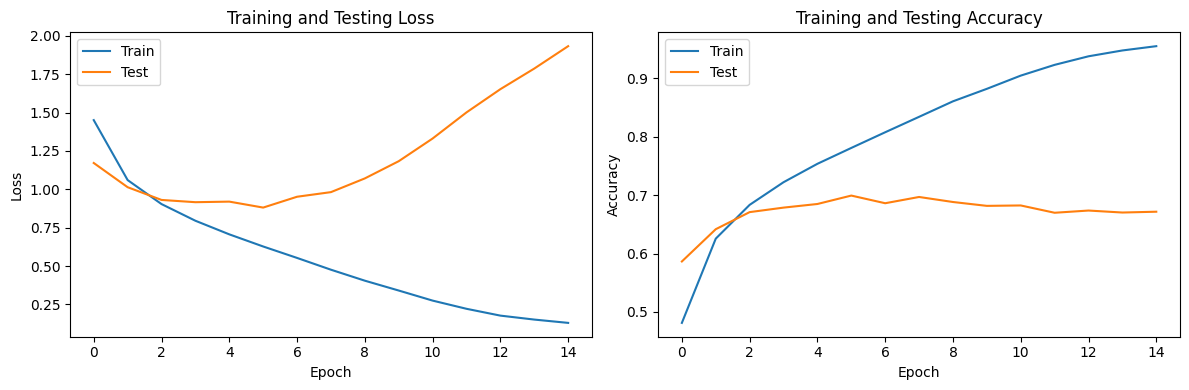

79/79 [==============================] - 1s 7ms/step - loss: 1.9392 - accuracy: 0.6715 - categorical_accuracy: 0.6715
Test Accuracy: 67.15%


In [180]:
#learning rate of 0.001 and Optimizer Adam, 2 blocks with 2 CNNs in each
# Train the model using the defined function
LR=0.001
model = create_my_cifar_cnn(number_blocks=2)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

train_cifar_10(model, train_ds, test_ds, NUM_EPOCHS, LR)

# Evaluate the model on the test set
test_metrics = model.evaluate(test_ds)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

**learning rate of 0.01 and Optimizer AdamGrad, 2 blocks with 2 CNNs in each**

  7%|▋         | 1/15 [00:05<01:22,  5.89s/it]

 Epoch 1, Loss: 1.8477, Accuracy: 31.99%, Test Loss: 1.5858, Test Accuracy: 41.00%


 13%|█▎        | 2/15 [00:11<01:14,  5.71s/it]

 Epoch 2, Loss: 1.5266, Accuracy: 44.24%, Test Loss: 1.5133, Test Accuracy: 45.29%


 20%|██        | 3/15 [00:17<01:08,  5.73s/it]

 Epoch 3, Loss: 1.3771, Accuracy: 50.28%, Test Loss: 1.3297, Test Accuracy: 52.92%


 27%|██▋       | 4/15 [00:22<01:02,  5.66s/it]

 Epoch 4, Loss: 1.2761, Accuracy: 54.33%, Test Loss: 1.3496, Test Accuracy: 52.28%


 33%|███▎      | 5/15 [00:26<00:48,  4.85s/it]

 Epoch 5, Loss: 1.2051, Accuracy: 56.95%, Test Loss: 1.3282, Test Accuracy: 54.18%


 40%|████      | 6/15 [00:31<00:45,  5.10s/it]

 Epoch 6, Loss: 1.1474, Accuracy: 58.83%, Test Loss: 1.3379, Test Accuracy: 54.63%


 47%|████▋     | 7/15 [00:37<00:42,  5.31s/it]

 Epoch 7, Loss: 1.0987, Accuracy: 60.65%, Test Loss: 1.3290, Test Accuracy: 53.96%


 53%|█████▎    | 8/15 [00:43<00:37,  5.40s/it]

 Epoch 8, Loss: 1.0699, Accuracy: 61.96%, Test Loss: 1.3658, Test Accuracy: 54.47%


 60%|██████    | 9/15 [00:47<00:30,  5.04s/it]

 Epoch 9, Loss: 1.0251, Accuracy: 63.37%, Test Loss: 1.4029, Test Accuracy: 54.22%


 67%|██████▋   | 10/15 [00:53<00:26,  5.26s/it]

 Epoch 10, Loss: 0.9865, Accuracy: 64.61%, Test Loss: 1.4100, Test Accuracy: 54.32%


 73%|███████▎  | 11/15 [00:58<00:21,  5.34s/it]

 Epoch 11, Loss: 0.9673, Accuracy: 65.35%, Test Loss: 1.5090, Test Accuracy: 53.08%


 80%|████████  | 12/15 [01:03<00:15,  5.18s/it]

 Epoch 12, Loss: 0.9230, Accuracy: 67.22%, Test Loss: 1.5215, Test Accuracy: 52.86%


 87%|████████▋ | 13/15 [01:06<00:09,  4.68s/it]

 Epoch 13, Loss: 0.9063, Accuracy: 67.66%, Test Loss: 1.5620, Test Accuracy: 53.72%


 93%|█████████▎| 14/15 [01:10<00:04,  4.30s/it]

 Epoch 14, Loss: 0.8864, Accuracy: 68.34%, Test Loss: 1.5151, Test Accuracy: 53.80%


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]

 Epoch 15, Loss: 0.8536, Accuracy: 69.35%, Test Loss: 1.6290, Test Accuracy: 53.05%


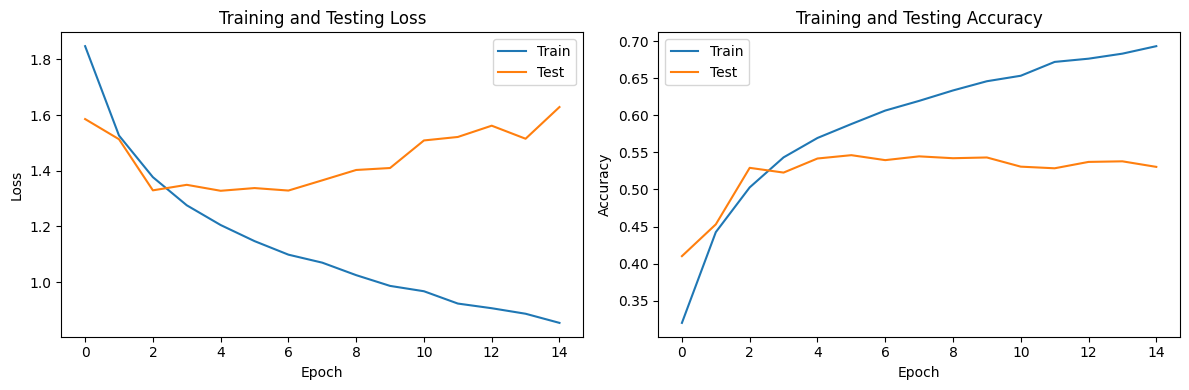

79/79 [==============================] - 1s 11ms/step - loss: 1.6300 - accuracy: 0.5305 - categorical_accuracy: 0.5305
Test Accuracy: 53.05%


In [181]:
#learning rate of 0.01 and Optimizer AdamGrad, 2 blocks with 2 CNNs in each
# Train the model using the defined function
LR=0.01
model = create_my_cifar_cnn(number_blocks=2)
model.compile(optimizer=tf.keras.optimizers.experimental.Adagrad(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

train_cifar_10(model, train_ds, test_ds, NUM_EPOCHS, LR)

# Evaluate the model on the test set
test_metrics = model.evaluate(test_ds)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

**learning rate of 0.001 and Optimizer AdamGrad, 2 blocks with 2 CNNs in each**

  7%|▋         | 1/15 [00:05<01:14,  5.34s/it]

 Epoch 1, Loss: 1.4341, Accuracy: 48.44%, Test Loss: 1.1582, Test Accuracy: 58.86%


 13%|█▎        | 2/15 [00:08<00:54,  4.23s/it]

 Epoch 2, Loss: 1.0472, Accuracy: 63.22%, Test Loss: 1.0107, Test Accuracy: 63.74%


 20%|██        | 3/15 [00:14<00:59,  4.93s/it]

 Epoch 3, Loss: 0.8925, Accuracy: 68.51%, Test Loss: 0.9145, Test Accuracy: 68.02%


 27%|██▋       | 4/15 [00:20<00:57,  5.25s/it]

 Epoch 4, Loss: 0.7668, Accuracy: 73.20%, Test Loss: 0.8887, Test Accuracy: 68.88%


 33%|███▎      | 5/15 [00:26<00:54,  5.43s/it]

 Epoch 5, Loss: 0.6748, Accuracy: 76.44%, Test Loss: 0.8677, Test Accuracy: 70.62%


 40%|████      | 6/15 [00:31<00:49,  5.54s/it]

 Epoch 6, Loss: 0.5770, Accuracy: 79.88%, Test Loss: 0.8981, Test Accuracy: 70.94%


 47%|████▋     | 7/15 [00:38<00:46,  5.82s/it]

 Epoch 7, Loss: 0.4891, Accuracy: 82.96%, Test Loss: 0.9067, Test Accuracy: 71.24%


 53%|█████▎    | 8/15 [00:41<00:35,  5.04s/it]

 Epoch 8, Loss: 0.4044, Accuracy: 85.87%, Test Loss: 0.9685, Test Accuracy: 70.55%


 60%|██████    | 9/15 [00:45<00:27,  4.59s/it]

 Epoch 9, Loss: 0.3278, Accuracy: 88.65%, Test Loss: 1.0971, Test Accuracy: 70.30%


 67%|██████▋   | 10/15 [00:49<00:22,  4.53s/it]

 Epoch 10, Loss: 0.2627, Accuracy: 90.81%, Test Loss: 1.2056, Test Accuracy: 70.00%


 73%|███████▎  | 11/15 [00:53<00:17,  4.32s/it]

 Epoch 11, Loss: 0.1945, Accuracy: 93.30%, Test Loss: 1.3647, Test Accuracy: 69.11%


 80%|████████  | 12/15 [00:56<00:11,  3.95s/it]

 Epoch 12, Loss: 0.1592, Accuracy: 94.60%, Test Loss: 1.5825, Test Accuracy: 68.60%


 87%|████████▋ | 13/15 [01:00<00:07,  3.89s/it]

 Epoch 13, Loss: 0.1373, Accuracy: 95.31%, Test Loss: 1.6398, Test Accuracy: 68.67%


 93%|█████████▎| 14/15 [01:05<00:04,  4.40s/it]

 Epoch 14, Loss: 0.1080, Accuracy: 96.28%, Test Loss: 1.8195, Test Accuracy: 68.61%


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]

 Epoch 15, Loss: 0.0905, Accuracy: 96.88%, Test Loss: 1.8797, Test Accuracy: 68.77%


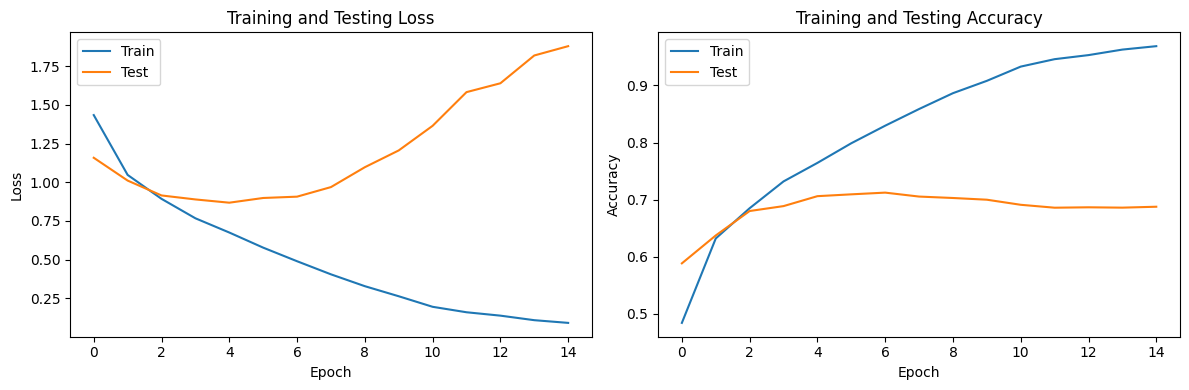

79/79 [==============================] - 1s 6ms/step - loss: 1.8871 - accuracy: 0.6877 - categorical_accuracy: 0.6877
Test Accuracy: 68.77%


In [182]:
#learning rate of 0.001 and Optimizer AdamGrad, 2 blocks with 2 CNNs in each
# Train the model using the defined function
LR=0.001
model = create_my_cifar_cnn(number_blocks=2)
model.compile(optimizer=tf.keras.optimizers.experimental.Adagrad(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

train_cifar_10(model, train_ds, test_ds, NUM_EPOCHS, LR)

# Evaluate the model on the test set
test_metrics = model.evaluate(test_ds)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')